# Risk Scoring & Underwriting
Risk Scoring and Underwriting are critical components in the financial and insurance industries, particularly in the evaluation and management of risk associated with lending, insurance policies, or other financial products.
## 1. Data Integration & Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

### Configuring Logging for the Application

Initialize a logging system to track application events and errors.

This setup is crucial for maintaining a record of application activity and diagnosing issues efficiently.

In [2]:
# Configure logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
# Check if handler already exists to avoid duplicate handlers
if not logger.handlers:
    handler = logging.FileHandler('app.log')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

### Define an ARDPreprocessor

Define an `ARDPreprocessor` class, which automates preprocessing tasks for risk data analysis. It includes:

- **Missing Value Handling**: Numeric features are imputed with the median, and categorical features are imputed with the most frequent value.
- **Feature Transformation**: Numeric data is scaled using `StandardScaler`, and categorical data is encoded using `OneHotEncoder`.
- **Pipeline and ColumnTransformer**: Combines preprocessing pipelines for both numeric and categorical features.
- **Data Loading and Logging**: Loads application and credit datasets, while logging data dimensions and any errors encountered.

In [3]:
# Define a class
class ARDPreprocessor:
    """
    Automated Risk Data (ARD) Preprocessing Module
    Handles missing values, encodes categorical variables, and scales numerical features.
    """
    # Constructor method to initialize the class
    def __init__(self, num_strategy='median', cat_strategy='most_frequent', scaler=StandardScaler(), encoder=OneHotEncoder(handle_unknown='ignore')):
        self.num_imputer = SimpleImputer(strategy=num_strategy)
        self.cat_imputer = SimpleImputer(strategy=cat_strategy)
        self.scaler = scaler
        self.encoder = encoder
        self.preprocessor = None    

    # Define a fit method to fit the preprocessing pipeline to the input data
    def fit(self, df, numeric_features, categorical_features):
        # Begin a try block to handle potential errors during fitting
        try:
            # Create a Pipeline for numeric features
            numeric_pipeline = Pipeline([
                ('imputer', self.num_imputer),
                ('scaler', self.scaler)
            ])
            # Create a Pipeline for categorical features
            categorical_pipeline = Pipeline([
                ('imputer', self.cat_imputer),
                ('encoder', self.encoder)
            ])
            # Combine the numeric and categorical pipelines into a single preprocessing object
            self.preprocessor = ColumnTransformer([
                ('num', numeric_pipeline, numeric_features),
                ('cat', categorical_pipeline, categorical_features)
            ])
            # Fit the ColumnTransformer to the input DataFrame df
            self.preprocessor.fit(df)
            logger.info("Preprocessor fitted successfully.")
        except Exception as e:
            logger.error(f"Error during fitting: {e}")
            raise

    # Apply the fitted preprocessing pipeline to transform the input data
    def transform(self, df):
        try:
            transformed_data = self.preprocessor.transform(df)
            feature_names = self.preprocessor.get_feature_names_out()
            return pd.DataFrame(transformed_data, columns=feature_names)
        except Exception as e:
            logger.error(f"Error during transformation: {e}")
            raise

    # Combine fitting and transformation into a single method
    def fit_transform(self, df, numeric_features, categorical_features):
        self.fit(df, numeric_features, categorical_features)
        return self.transform(df)

# Load and combine multiple datasets
try:
    application_df = pd.read_csv('application_record.csv')
    credit_df = pd.read_csv('credit_record.csv')
    
    logger.info(f"Loaded application data: {application_df.shape} rows")
    logger.info(f"Loaded credit data: {credit_df.shape} rows")
    
except Exception as e:
    logger.error(f"Error loading data: {e}")
    raise

The `ARDPreprocessor` class is a modular and reusable preprocessing module.

- It handles missing values, scales numeric features, and encodes categorical features.

- It uses `Pipeline` and `ColumnTransformer` for a clean and consistent workflow.

- It includes error handling and logging for robustness.

- The `fit_transform` method provides a convenient way to fit and transform data in one step.

Here's a breakdown of the steps:

1. Fitting:

- The `SimpleImputer` learns the mean (or other specified statistic) of the numeric features.

- The `StandardScaler` computes the mean and standard deviation of the numeric features.

2. Transformation:

- The `SimpleImputer` replaces missing values with the learned mean.

- The `StandardScaler` standardizes the features using the computed mean and standard deviation.

### Create risk labels

This function, `create_risk_labels`, prepares credit data by generating risk labels for each client:

- **Aggregate Credit Records**: Groups the dataset by client ID (`'ID'`) and counts occurrences of each credit status.
- **Identify High-Risk Statuses**: Labels delinquency statuses (`'2'`, `'3'`, `'4'`, `'5'`) as high risk.
- **Risk Flag Assignment**: Creates a new DataFrame (`risk_flags`) and assigns a risk flag:
  - `1`: Client has any high-risk status.
  - `0`: Client has no high-risk statuses.
- **Output**: Returns a DataFrame containing client IDs and their corresponding risk flags.

This logic is crucial for distinguishing high-risk clients based on credit data.

In [4]:
# Data preparation - properly join the datasets
# First, aggregate credit records to create risk labels per client
def create_risk_labels(credit_df):
    # Count occurrences of each status per client
    status_counts = credit_df.groupby('ID')['STATUS'].apply(lambda x: x.value_counts()).unstack().fillna(0)
    
    # Define high risk statuses (2-5 are delinquencies)
    high_risk_statuses = ['2', '3', '4', '5']
    
    # Create risk flag: 1 if client has any high risk status, 0 otherwise
    risk_flags = pd.DataFrame(index=status_counts.index)
    risk_flags['risk_flag'] = 0
    
    for status in high_risk_statuses:
        if status in status_counts.columns:
            risk_flags.loc[status_counts[status] > 0, 'risk_flag'] = 1
    
    return risk_flags

**Create Risk Labels**:
   - The `create_risk_labels` function processes the credit data to generate risk flags for each client.
   - The `value_counts(normalize=True)` provides the relative distribution of risk flags (`0` and `1`) for quick analysis.

**Merge Datasets**:
   - The application data (`application_df`) is merged with the risk labels (`risk_labels`) using the `ID` field as the common key.
   - This ensures that each client's risk flag is incorporated into the application data.
   - The resulting merged dataset's shape is printed to verify the successful join.

This step prepares a combined dataset that integrates risk insights with application details for further analysis.

In [5]:
# Create risk labels
risk_labels = create_risk_labels(credit_df)
print(f"Risk label distribution:\n{risk_labels['risk_flag'].value_counts(normalize=True)}")

# Merge application data with risk labels
df = application_df.merge(risk_labels, left_on='ID', right_index=True, how='inner')
print(f"Merged dataset shape: {df.shape}")

Risk label distribution:
risk_flag
0    0.985495
1    0.014505
Name: proportion, dtype: float64
Merged dataset shape: (36457, 19)


In [6]:
# Feature Engineering
# Handle missing values first
print("\nMissing values before imputation:")
print(df.isnull().sum())


Missing values before imputation:
ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
risk_flag                  0
dtype: int64


In [7]:
# Create new features
df['income_log'] = np.log1p(df['AMT_INCOME_TOTAL'].replace(0, np.nan))  # Replace zero values before log transformation
df['age_years'] = (-df['DAYS_BIRTH']) // 365
df['employment_length_years'] = (-df['DAYS_EMPLOYED']).clip(lower=0) // 365  # Clip negative values
df['dependents'] = df['CNT_FAM_MEMBERS'] - df['CNT_CHILDREN']
df['has_car_property'] = ((df['FLAG_OWN_CAR'] == 'Y') | (df['FLAG_OWN_REALTY'] == 'Y')).astype(int)

### Feature Transformations & Rationale

| Feature Name              | Transformation Applied                                           | Rationale |
|---------------------------|----------------------------------------------------------------|-----------|
| `income_log`              | Log transformation on `AMT_INCOME_TOTAL`                      | Normalizes skewed income distribution for better model performance. |
| `age_years`              | Converted `DAYS_BIRTH` from days to years (`-DAYS_BIRTH / 365`) | Improves interpretability by representing age in a standard format. |
| `employment_length_years` | Converted `DAYS_EMPLOYED` to years (`-DAYS_EMPLOYED / 365`), clipped negatives | Handles anomalies where negative values exist and provides meaningful employment duration. |
| `dependents`             | Computed as `CNT_FAM_MEMBERS - CNT_CHILDREN`                   | Better represents financial dependents than just counting children. |
| `has_car_property`       | Created a binary flag from `FLAG_OWN_CAR` and `FLAG_OWN_REALTY` (`1 if Y, else 0`) | Indicates asset ownership, which may impact financial stability. |

In [8]:
# Handle extreme values and outliers
for col in ['income_log', 'age_years', 'employment_length_years']:
    q1 = df[col].quantile(0.01)
    q3 = df[col].quantile(0.99)
    df[col] = df[col].clip(q1, q3)

This loop addresses extreme values and outliers in key numeric columns (`'income_log'`, `'age_years'`, and `'employment_length_years'`):

- **Quantile Calculation**: 
  - `q1`: The 1st percentile (lower bound).
  - `q3`: The 99th percentile (upper bound).
  
- **Outlier Handling**: The `.clip(q1, q3)` method ensures that values below `q1` are set to `q1`, and values above `q3` are set to `q3`.

By limiting extreme values, this step reduces the influence of outliers, improving the robustness of subsequent analyses or model training.


In [9]:
# Drop original columns after transformation
df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)

#### Visualizations for Feature Validation
To ensure that our engineered features differentiate well between low- and high-risk borrowers, we used visualizations:
##### 1. Log-Transformed Income Distribution
- To check whether log transformation normalizes income distribution.
- Histogram with KDE (Kernel Density Estimation) line to visualize the data's probability density.

This section visualizes the distribution of the log-transformed income variable.

It provides insights into the income data's distribution and helps identify patterns or anomalies.


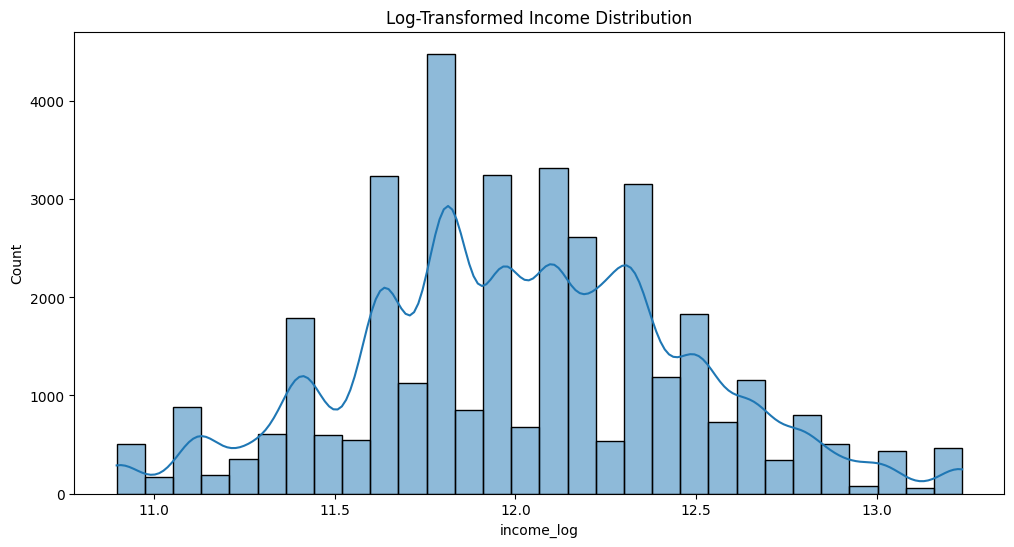

In [10]:
# Visualize data distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['income_log'], bins=30, kde=True)
plt.title("Log-Transformed Income Distribution")
plt.show()

- The distribution appears approximately normal, though slightly right-skewed.

- Some outliers on the higher end (>13.0) indicate a few very high-income individuals.

- The left tail is shorter, suggesting fewer low-income individuals.

**Why Log Transformation?**

- The original income distribution was likely highly skewed, making it harder for models to learn patterns.
- Log transformation reduces the impact of extreme values and normalizes the distribution for better modeling.

**Implications for Risk Scoring:**

- Income is typically negatively correlated with default risk (lower income → higher risk).
- The log transformation ensures that differences in income have a more proportional effect on risk calculations.
- A model trained on log-transformed income may perform better in distinguishing high- and low-risk individuals.

##### 2. Age Distribution
- To verify if the age distribution is reasonable.
- Histogram with Kernel Density Estimate (KDE) line to represent the distribution's probability density.

This plot allows to observe the age distribution in your dataset, including its shape, central tendencies, and possible outliers.


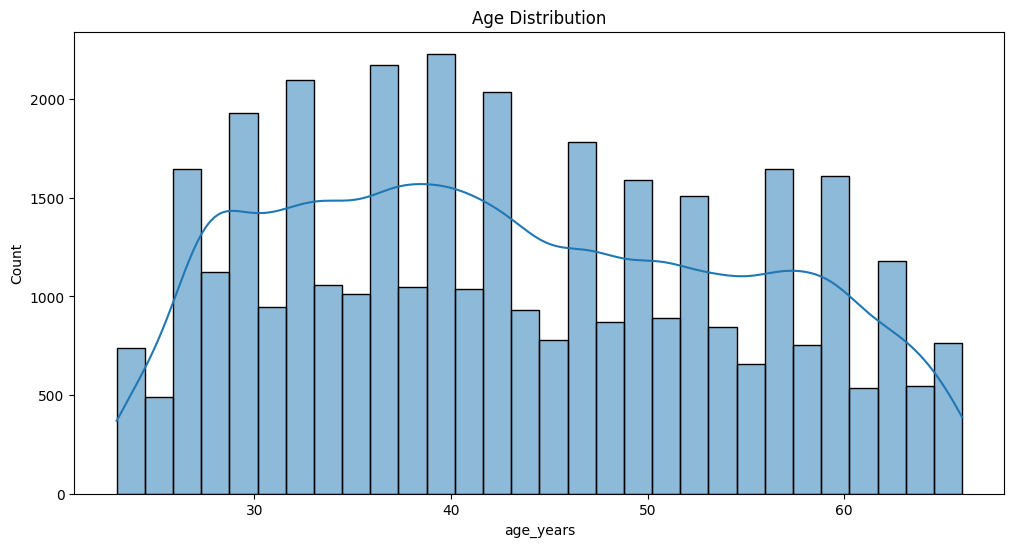

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['age_years'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

- The histogram shows the age distribution in the dataset.
- The distribution appears relatively uniform, with some peaks around 30–40 years old and another around 50–60 years old.
- The distribution suggests that the dataset contains a balanced mix of younger and older individuals.
- The kernel density estimate (KDE) overlay smooths out the trends, showing that the age distribution is slightly right-skewed but relatively even.
- The age distribution indicates that the dataset covers a broad range of individuals, which is good for generalizing risk-scoring models.

##### 3. Income by Risk Category
- To analyze whether income level impacts risk categorization.
- Boxplot showing income_log distribution by risk_flag.

This visualization explores the relationship between `income_log` (log-transformed income) and the target variable `risk_flag`.

It highlights variations in income distribution across risk categories, helping to analyze potential patterns or disparities in the data.


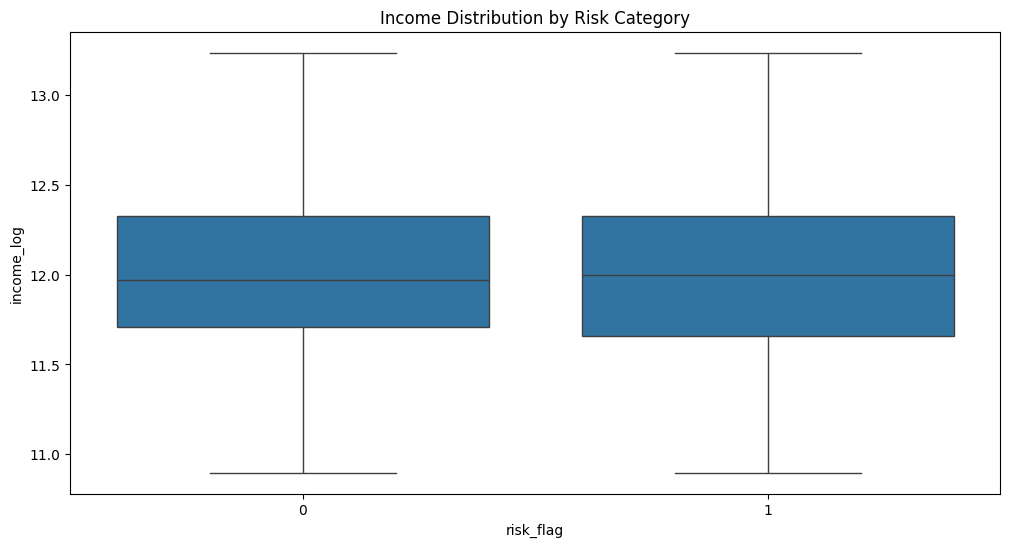

In [12]:
# Visualize relationship between features and target
plt.figure(figsize=(12, 6))
sns.boxplot(x='risk_flag', y='income_log', data=df)
plt.title("Income Distribution by Risk Category")
plt.show()

- This box plot compares log-transformed income distributions across different risk categories (0 = Low Risk, 1 = High Risk).
- Both categories exhibit similar median incomes and interquartile ranges, indicating no strong income disparity between the two risk groups.
- The whiskers show a wide range of income values in both groups, suggesting high variance.

- Income alone may not be a strong differentiator between risk categories. Combining it with other features (e.g., debt-to-income ratio, employment length) could improve risk assessment.

##### 4. Age by Risk Category

- To check if age correlates with risk levels.
- Boxplot showing age_years distribution by risk_flag.

This boxplot examines the relationship between `age_years` (age) and the target variable `risk_flag`.

The resulting boxplot highlights how the age distribution differs between low-risk and high-risk categories, offering insights into any trends or disparities.


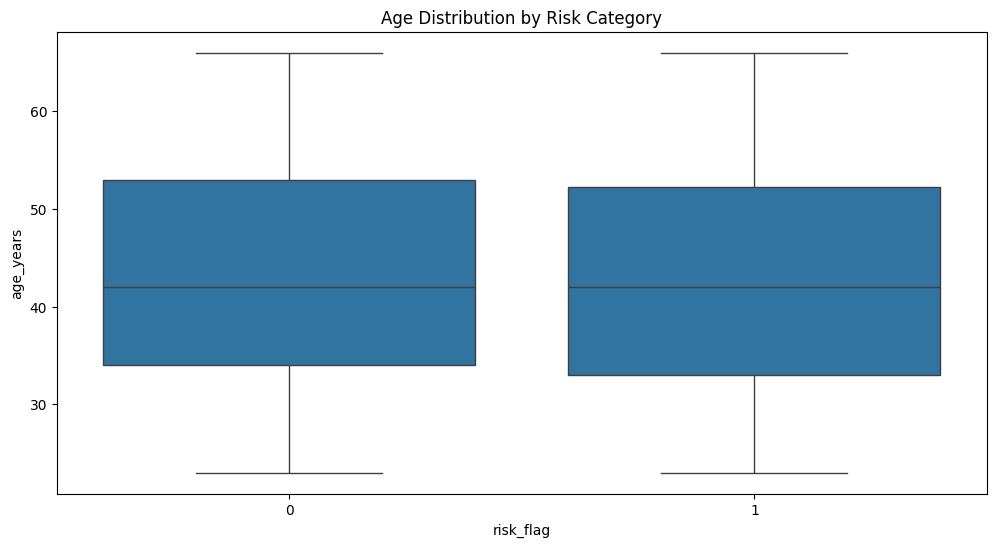

In [13]:
# Visualize relationship between features and target
plt.figure(figsize=(12, 6))
sns.boxplot(x='risk_flag', y='age_years', data=df)
plt.title("Age Distribution by Risk Category")
plt.show()

The box plot displays the distribution of `age_years` for the two risk categories (`risk_flag = 0` and `risk_flag = 1`):

- Both categories exhibit a **similar age distribution**:
  - Median age: Approximately 45 years.
  - Interquartile Range (IQR): Spanning from 35 to 55 years.
  - Whiskers: Extending from 25 to 65 years.
  
- There is no significant difference in age distribution between low-risk (`risk_flag = 0`) and high-risk (`risk_flag = 1`) groups. This suggests that age may not strongly influence the classification of risk flags in this dataset.

This visualization helps to confirm or refute any hypotheses regarding age's impact on risk categories.


##### 5. Risk Flag Distribution

This bar chart visualizes the distribution of the target variable, `risk_flag`-

It helps to observe the class distribution and ensures there is or not significant class imbalance, which is crucial for model performance and fairness.


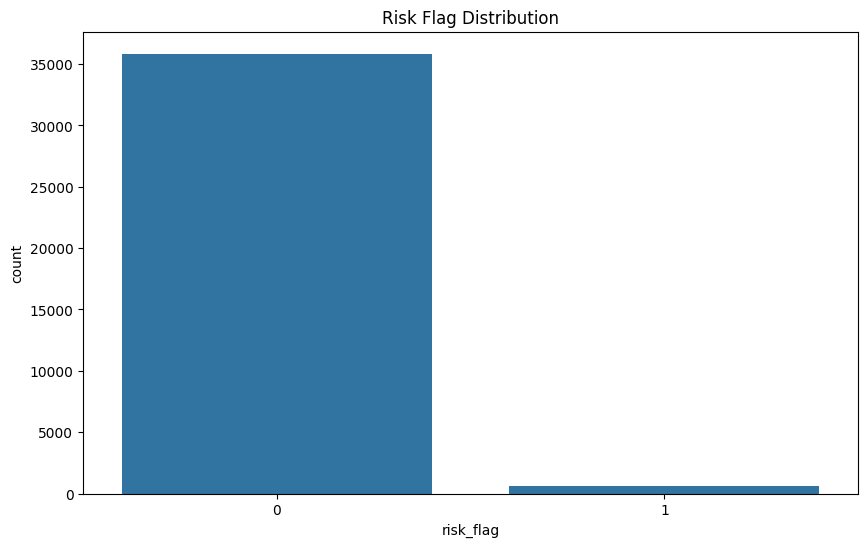

In [14]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='risk_flag', data=df)
plt.title("Risk Flag Distribution")
plt.show()

Class Imbalance: The visualization likely reveals an uneven distribution between the two classes (0 for low risk, 1 for high risk).

The bar for 0 is significantly taller, it suggests most clients are low risk.

A smaller bar for 1 indicates fewer high-risk clients in the dataset.

##### 6. Feature Correlation Matrix

This matrix visualizes the correlation between numeric features in the dataset.

- Calculate the Pearson correlation matrix for the numeric columns.

This heatmap is a powerful tool for identifying strong correlations between features, which can be useful for feature engineering or understanding potential multicollinearity in the dataset.


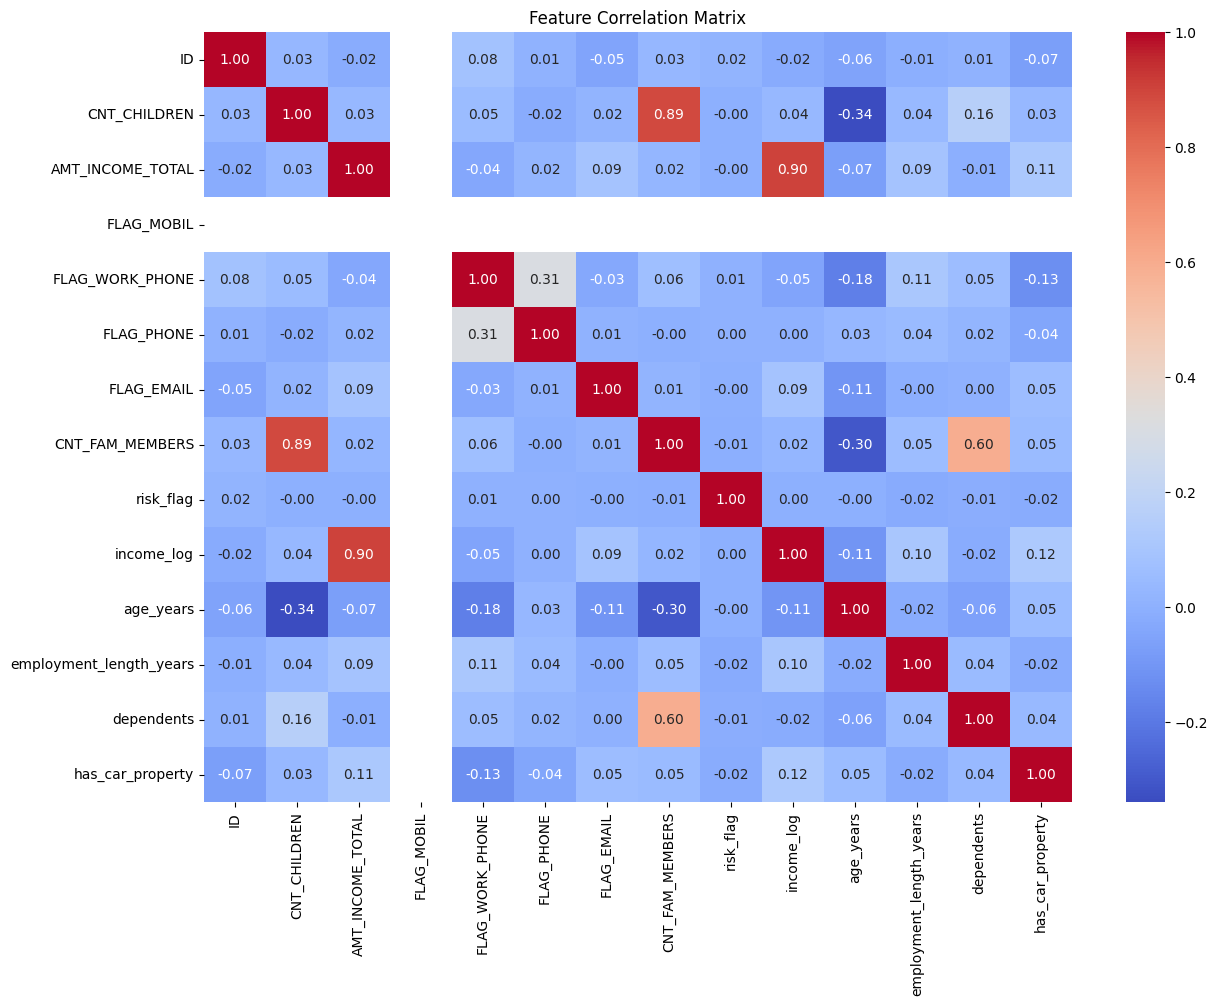

In [15]:
# Check correlation between features
plt.figure(figsize=(14, 10))
numeric_cols = df.select_dtypes(include=['number']).columns
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

1. **Strong Positive Correlations**:
   - `CNT_CHILDREN` and `CNT_FAM_MEMBERS` (0.89): This is expected as the number of children is likely related to family size.
   - `AMT_INCOME_TOTAL` and `income_log` (0.90): Indicates that the log transformation of income effectively preserves its linear relationships with other features.

2. **Moderate Positive Correlations**:
   - `dependents` and `CNT_FAM_MEMBERS` (0.60): Suggests that dependents contribute significantly to family size.

3. **Moderate negative Correlations**:
   - `age_years` has a moderate negative correlation with `CNT_FAM_MEMBERS` (-0.30) and `CNT_CHILDREN` (-0.34), which might indicate that older individuals might have smaller families and less children.

4. **Potential Redundancy**:
   - Features like `CNT_CHILDREN` and `CNT_FAM_MEMBERS` may introduce redundancy due to their high correlation. It may consider dropping or combining one during feature engineering.

5. **Uncorrelated Features**:
   - Several features, like `FLAG_MOBIL` or `FLAG_EMAIL`, seem to have near-zero correlations with others, suggesting limited contribution to overall data variability.

6. **Low Correlation with Target (risk_flag)**:
    - Most features have very low correlation with the target variable (risk_flag), which suggests that the target may not be linearly related to these features. This could indicate the need for more complex models or feature engineering.

##### Possible Step:
- Investigate high correlations further for feature selection or dimensionality reduction (e.g., PCA).


In [16]:
# Check the shape of the dataset (rows, columns)
print("Dataset shape (rows, columns):\n", df.shape)

# Get dataset information (column names, non-null counts, data types)
print("Dataset Info:\n")
df.info()

# Display first 5 rows
print("\nFirst 5 rows:\n", df.head())

# Summary statistics for numerical columns
print("Summary statistics:\n", df.describe())

# Check for missing values in numerical columns
print("Missing values in numerical columns:\n", df.isnull().sum())

Dataset shape (rows, columns):
 (36457, 22)
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 0 to 434812
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       36457 non-null  int64  
 1   CODE_GENDER              36457 non-null  object 
 2   FLAG_OWN_CAR             36457 non-null  object 
 3   FLAG_OWN_REALTY          36457 non-null  object 
 4   CNT_CHILDREN             36457 non-null  int64  
 5   AMT_INCOME_TOTAL         36457 non-null  float64
 6   NAME_INCOME_TYPE         36457 non-null  object 
 7   NAME_EDUCATION_TYPE      36457 non-null  object 
 8   NAME_FAMILY_STATUS       36457 non-null  object 
 9   NAME_HOUSING_TYPE        36457 non-null  object 
 10  FLAG_MOBIL               36457 non-null  int64  
 11  FLAG_WORK_PHONE          36457 non-null  int64  
 12  FLAG_PHONE               36457 non-null  int64  
 13  FLAG_EMAIL           


The dataset's features are organized into two categories. This separation allows efficient preprocessing:
- **Numerical features** can be imputed, scaled, or transformed.
- **Categorical features** can be imputed and encoded using techniques like one-hot encoding.

In [17]:
# Define numerical and categorical features
numeric_features = [
    'income_log', 'age_years', 'employment_length_years', 
    'dependents', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 
    'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'
]

categorical_features = [
    'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
    'has_car_property'
]

Preprocess the dataset using the `ARDPreprocessor` class and prepare the features (`X`) and target (`y`) for modeling:

1. **Initialize Preprocessor**:
   - `preprocessor = ARDPreprocessor()` creates an instance of the custom preprocessing class.
   
2. **Fit and Transform Data**:
   - `preprocessor.fit_transform(df, numeric_features, categorical_features)` applies the preprocessing pipeline:
     - **Numeric Features**: Imputes missing values, scales numerical variables.
     - **Categorical Features**: Handles missing data, encodes categorical variables.
   - Returns the fully preprocessed dataset, stored in `processed_data`.

3. **Define Features and Target**:
   - `X = processed_data`: Sets the preprocessed features as `X`.
   - `y = df['risk_flag']`: Extracts the target variable (`risk_flag`) for risk classification.

In [18]:
# Preprocess data using ARD module
preprocessor = ARDPreprocessor()
processed_data = preprocessor.fit_transform(df, numeric_features, categorical_features)
X = processed_data
y = df['risk_flag']

In [19]:
# Print class distribution
print("\nClass distribution in the dataset:")
print(y.value_counts(normalize=True))


Class distribution in the dataset:
risk_flag
0    0.983103
1    0.016897
Name: proportion, dtype: float64


The class distribution in the dataset indicates it is highly imbalanced and we need to handle class imbalance

## 3. Model Development & Evaluation

First, we divide the dataset into training and testing sets for model evaluation:

- Function `train_test_split()` from Scikit-learn performs the split.

Parameters:
- `test_size=0.2`: Allocates 20% of the data for testing and 80% for training.
- `random_state=42`: Ensures reproducibility by fixing the random seed.
- `stratify=y`: Ensures the target variable's class distribution is preserved in both the training and testing sets, which is important when dealing with imbalanced datasets.

Outputs:
- `X_train`, `y_train`: Training data and corresponding labels.
- `X_test`, `y_test`: Testing data and corresponding labels.

This ensures the model is trained on one part of the data and tested on a separate portion to evaluate its performance.


In [20]:
# Split data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Then, we handle class imbalance.
1. **Synthetic Minority Oversampling Technique (SMOTE)**:
   - SMOTE generates synthetic samples for the minority class to address class imbalance without simply duplicating existing samples.
   - `sampling_strategy=0.2`: Indicates that the minority class will constitute 20% of the majority class after oversampling.

2. **Implementation**:
   - `smote = SMOTE(sampling_strategy=0.2, random_state=42)` initializes SMOTE with the specified ratio and a fixed random state for reproducibility.
   - `X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)` applies SMOTE to the training data (`X_train`, `y_train`), creating balanced training sets (`X_train_bal`, `y_train_bal`).


In [21]:
# Apply SMOTE with a conservative ratio
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("\nTraining class distribution after balancing:")
print(pd.Series(y_train_bal).value_counts(normalize=True))


Training class distribution after balancing:
risk_flag
0    0.833343
1    0.166657
Name: proportion, dtype: float64


C:\myProjects\Risk-Scoring-Underwriting\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\myProjects\Risk-Scoring-Underwriting\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\sghas\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sghas\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in __init__
    

Define a function to evaluate the performance of a machine learning model using various metrics and visualizations:

1. **Inputs**:
   - `model`: The machine learning model to evaluate.
   - `X_test`, `y_test`: Testing data and labels.
   - `model_name`: Label the model during logging and plotting.

2. **Predictions**:
   - `y_pred = model.predict(X_test)`: Makes binary class predictions.
   - `y_pred_proba = model.predict_proba(X_test)[:, 1]`: Predicts probabilities for the positive class, used for ROC-AUC and ROC curve.

3. **Evaluation Metrics**:
   - **Accuracy**: Fraction of correct predictions.
   - **Precision**: Proportion of true positives out of predicted positives.
   - **Recall**: Proportion of true positives out of actual positives.
   - **F1 Score**: Harmonic mean of precision and recall.
   - **ROC-AUC**: Measures the model's ability to distinguish between classes.

4. **ROC Curve**:
   - Plots the trade-off between the true positive rate (TPR) and false positive rate (FPR).
   - The diagonal line (`'k--'`) represents a random classifier.


In [22]:
# Model Training & Evaluation
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    logger.info(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    
    # Print metrics to the cell output
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return accuracy, precision, recall, f1, roc_auc

#### Logistic Regression Training and Evaluation

1. **Initialize Logistic Regression Model**:
   - `LogisticRegression()`: Implements a logistic regression classifier.
   - `class_weight='balanced'`: Automatically adjusts weights inversely proportional to class frequencies to handle class imbalance.
   - `max_iter=1000`: Increases the maximum number of iterations for the solver to converge.
   - `random_state=42`: Ensures reproducibility by fixing the random seed.
   - `C=0.1`: Introduces stronger regularization (smaller values of `C` increase regularization strength), which helps prevent overfitting.

2. **Fit the Model**:
   - `lr_model.fit(X_train_bal, y_train_bal)`: Trains the model on the balanced training dataset (from SMOTE).

3. **Evaluate the Model**:
   - `evaluate_model()`: Calls the evaluation function to assess the model's performance.
     - Calculates metrics such as accuracy, precision, recall, F1 score, and ROC-AUC.
     - Logs the results and provides visual feedback (e.g., ROC curve, confusion matrix, classification report).

4. **Store Metrics**:
   - `lr_metrics`: Stores evaluation metrics returned by the `evaluate_model` function for future comparisons across models.



Logistic Regression Evaluation:
Accuracy: 0.5417
Precision: 0.0183
Recall: 0.4959
F1 Score: 0.0352
ROC-AUC: 0.5249

Confusion Matrix:
[[3889 3280]
 [  62   61]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.54      0.70      7169
           1       0.02      0.50      0.04       123

    accuracy                           0.54      7292
   macro avg       0.50      0.52      0.37      7292
weighted avg       0.97      0.54      0.69      7292



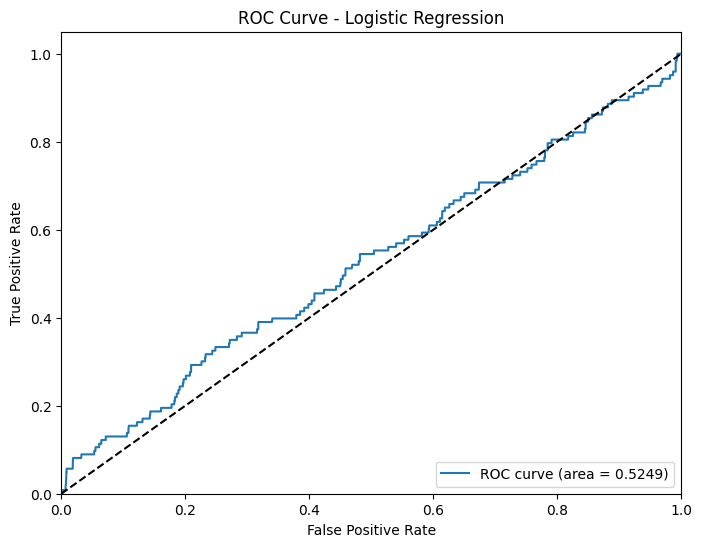

In [23]:
# Train and evaluate multiple models
# Logistic Regression
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    C=0.1  # Stronger regularization
)
lr_model.fit(X_train_bal, y_train_bal)
lr_metrics = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")

- AUC = 0.5249:

  - The area under the ROC curve is 0.5249, which is slightly better than random guessing (0.5).

  - This indicates that the Logistic Regression model has some predictive power, but it is not very strong.


#### Random Forest


Random Forest Evaluation:
Accuracy: 0.9047
Precision: 0.0327
Recall: 0.1626
F1 Score: 0.0544
ROC-AUC: 0.5779

Confusion Matrix:
[[6577  592]
 [ 103   20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7169
           1       0.03      0.16      0.05       123

    accuracy                           0.90      7292
   macro avg       0.51      0.54      0.50      7292
weighted avg       0.97      0.90      0.93      7292



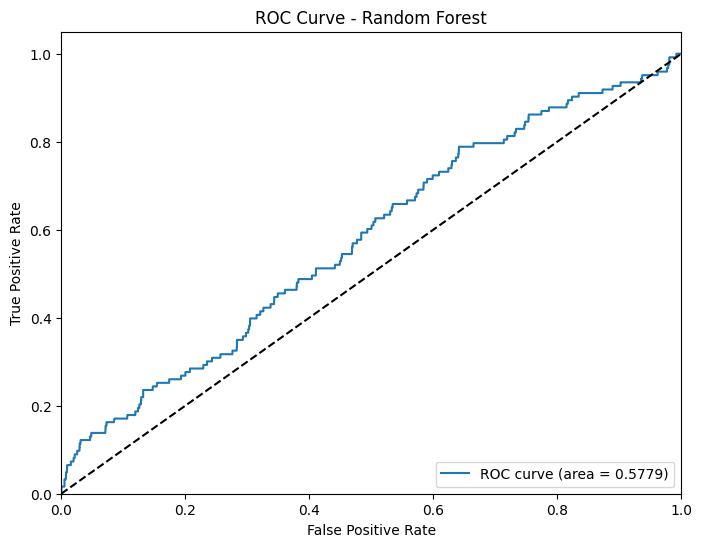

In [24]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)
rf_model.fit(X_train_bal, y_train_bal)
rf_metrics = evaluate_model(rf_model, X_test, y_test, "Random Forest")

- AUC = 0.5779:

  - The area under the ROC curve is 0.5779, which is better than random guessing (0.5) but still indicates limited predictive power.

  - This suggests that the Random Forest model performs better than the Logistic Regression model (AUC = 0.5249) but still has room for improvement.

#### XGBoost


XGBoost Evaluation:
Accuracy: 0.9380
Precision: 0.0418
Recall: 0.1220
F1 Score: 0.0622
ROC-AUC: 0.5593

Confusion Matrix:
[[6825  344]
 [ 108   15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      7169
           1       0.04      0.12      0.06       123

    accuracy                           0.94      7292
   macro avg       0.51      0.54      0.52      7292
weighted avg       0.97      0.94      0.95      7292



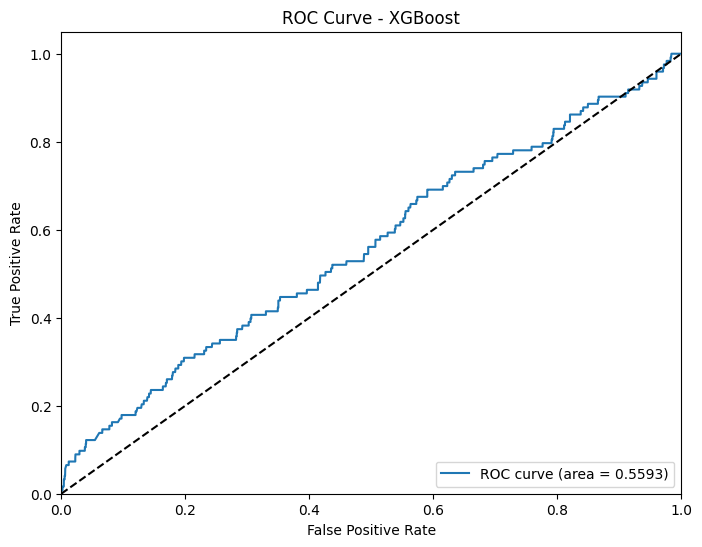

In [25]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    random_state=42
)
xgb_model.fit(X_train_bal, y_train_bal)
xgb_metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

- AUC = 0.5593:

  - The area under the ROC curve is 0.5593, which is better than random guessing (0.5) but still indicates limited predictive power.

  - This suggests that the XGBoost model performs better than random guessing but still has room for improvement.

#### Comparing Model Performances
We compare models and select the one most effective for the task, ensuring balanced evaluation metrics.
1. **Model Names and Metrics**:
   - `models`: A list of models being compared (`Logistic Regression`, `Random Forest`, `XGBoost`).
   - `metrics`: A list of metric tuples corresponding to each model. Each tuple contains:
     - Accuracy, Precision, Recall, F1 Score, and ROC-AUC (indexed 0 to 4).

2. **Identify the Best Model**:
   - `np.argmax([m[3] for m in metrics])`: Finds the index of the model with the highest F1 Score (`m[3]`), which balances precision and recall.
   - `best_model_name`: Retrieves the name of the best model using the index.

3. **Print Model Summaries**:
   - Loops through each model and prints its performance metrics in a clear and organized format.

4. **Highlight the Best Model**:
   - The best-performing model is identified and displayed along with its F1 Score.


In [27]:
# Compare model performances
models = ["Logistic Regression", "Random Forest", "XGBoost"]
metrics = [lr_metrics, rf_metrics, xgb_metrics]

# Find best model based on F1 score
best_idx = np.argmax([m[3] for m in metrics])  # F1 score is at index 3
best_model_name = models[best_idx]

print("\n=== Model Comparison ===")
for i, model_name in enumerate(models):
    print(f"\n{model_name} Summary:")
    print(f"Accuracy: {metrics[i][0]:.4f}")
    print(f"Precision: {metrics[i][1]:.4f}")
    print(f"Recall: {metrics[i][2]:.4f}")
    print(f"F1 Score: {metrics[i][3]:.4f}")
    print(f"ROC-AUC: {metrics[i][4]:.4f}")

print(f"\nBest model: {best_model_name} with F1 Score: {metrics[best_idx][3]:.4f}")


=== Model Comparison ===

Logistic Regression Summary:
Accuracy: 0.5417
Precision: 0.0183
Recall: 0.4959
F1 Score: 0.0352
ROC-AUC: 0.5249

Random Forest Summary:
Accuracy: 0.9047
Precision: 0.0327
Recall: 0.1626
F1 Score: 0.0544
ROC-AUC: 0.5779

XGBoost Summary:
Accuracy: 0.9380
Precision: 0.0418
Recall: 0.1220
F1 Score: 0.0622
ROC-AUC: 0.5593

Best model: XGBoost with F1 Score: 0.0622


- Accuracy:

  - The proportion of correctly classified instances out of the total instances.

  - XGBoost has the highest accuracy (0.9380), followed by Random Forest (0.9047) and Logistic Regression (0.5417).

- Precision:

  - The proportion of true positive predictions out of all positive predictions.

  - XGBoost has the highest precision (0.0418), but all models have low precision, indicating many false positives.

- Recall:

  - The proportion of true positives correctly identified out of all actual positives.

  - Logistic Regression has the highest recall (0.4959), but it comes at the cost of low precision.

- F1 Score:

  - The harmonic mean of precision and recall.

  - XGBoost has the highest F1 score (0.0622), making it the best model based on this metric.

- ROC-AUC:

  - The area under the ROC curve, measuring the model's ability to distinguish between classes.

  - Random Forest has the highest ROC-AUC (0.5779), but all models have relatively low AUC values.
 
##### Model Performance:

- XGBoost performs the best overall, with the highest accuracy and F1 score.

- Random Forest has the highest ROC-AUC, indicating better class separation.

- Logistic Regression has the highest recall but suffers from low precision and F1 score.

##### Low Precision and F1 Scores:

- All models have low precision and F1 scores, suggesting a high number of false positives.

- This could be due to class imbalance or the need for better feature engineering.

##### High Accuracy:

- XGBoost and Random Forest have high accuracy, but this might be misleading if the dataset is imbalanced.

- Always consider precision, recall, and F1 score for imbalanced datasets.


In [30]:
for model, model_name in zip([lr_model, rf_model, xgb_model], ["Logistic Regression", "Random Forest", "XGBoost"]):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n{model_name} Probability Summary:")
    print(pd.Series(y_pred_proba).describe())


Logistic Regression Probability Summary:
count    7292.000000
mean        0.469901
std         0.131211
min         0.063168
25%         0.384959
50%         0.486656
75%         0.558723
max         0.849143
dtype: float64

Random Forest Probability Summary:
count    7292.000000
mean        0.367379
std         0.105787
min         0.102567
25%         0.279409
50%         0.374381
75%         0.460353
max         0.696364
dtype: float64

XGBoost Probability Summary:
count    7292.000000
mean        0.314342
std         0.125528
min         0.038753
25%         0.210253
50%         0.312916
75%         0.417927
max         0.734191
dtype: float64


- Mean Probability:

  - Logistic Regression has the highest mean probability (0.4699), indicating that it tends to predict higher probabilities for the positive class compared to Random Forest (0.3674) and XGBoost (0.3143).

- Standard Deviation:

  - XGBoost has the highest standard deviation (0.1255), suggesting more variability in its predicted probabilities compared to the other models.

- Range of Probabilities:

  - Logistic Regression has the widest range of probabilities (from 0.0632 to 0.8491), indicating that it produces more extreme predictions.

  - XGBoost has the lowest minimum probability (0.0388), which might indicate that it is more conservative in predicting the positive class.

- Median Probability:

  - The median probability for all models is close to the mean, suggesting a relatively symmetric distribution of predicted probabilities.
 
Model Comparison:

- Logistic Regression tends to produce higher probabilities, which might lead to more false positives.

- XGBoost produces lower probabilities, which might result in fewer false positives but also fewer true positives.

#### Calibration Curves

   - A graphical plot that shows how well the predicted probabilities from a model match the actual probabilities.
   - Calibration curves assess the reliability of predicted probabilities from classification models.
   - They compare predicted probabilities (`prob_pred`) with the true fraction of positives (`prob_true`) in each bin.
   - The x-axis represents the predicted probability (binned into intervals).
   - The y-axis represents the fraction of positives (actual proportion of positive class instances in each bin).

**Setup**:
   - **`calibration_curve`**: Computes the calibration curve for each model:
     - `y_test`: True labels.
     - `y_pred_proba`: Predicted probabilities for the positive class (obtained using `model.predict_proba(X_test)[:, 1]`).
     - `n_bins=10`: Divides probabilities into 10 bins for analysis.
     - `strategy='uniform'`: Ensures bins have equal widths.

**Plot for Each Model**:
   - Iterates through the models (`lr_model`, `rf_model`, `xgb_model`) and their names.
   - Plots the calibration curves (prob_true vs. prob_pred) with markers for visual clarity.

**Perfect Calibration Line**:
   - `plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")` adds a dashed diagonal line to represent ideal calibration (predicted probabilities match true probabilities perfectly).

**Final Touches**:
   - Labels (`plt.xlabel`, `plt.ylabel`): Indicate the axes for "Predicted Probability" and "Fraction of Positives."
   - Title (`plt.title`): Describes the plot ("Calibration Curves").
   - Legend (`plt.legend`): Identifies the models.
   - Grid (`plt.grid`): Adds a grid for better readability.
   - `plt.show()`: Displays the plot.

This visualization reveals whether a model's predicted probabilities are well-calibrated, helping to identify any overconfidence or underconfidence in predictions.


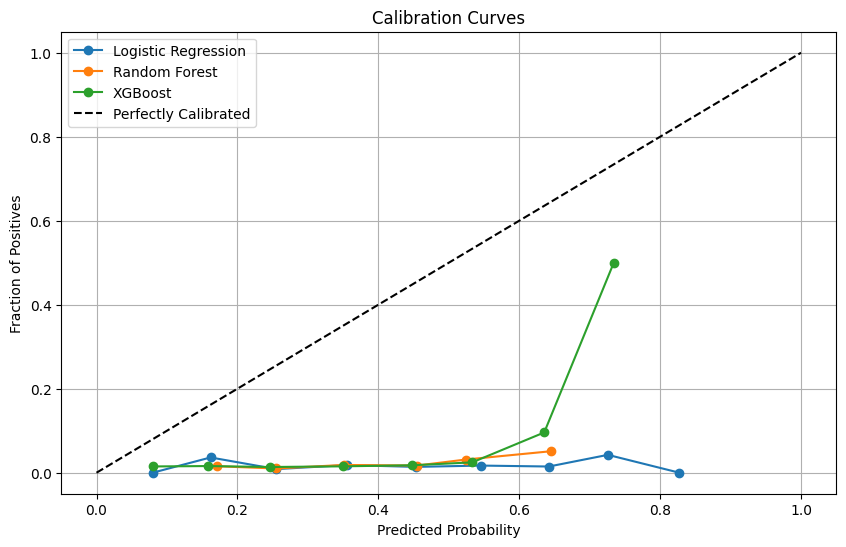

In [31]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 6))

for model, model_name in zip([lr_model, rf_model, xgb_model], ["Logistic Regression", "Random Forest", "XGBoost"]):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute calibration curve (fraction of positives per bin)
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')
    
    # Plot reliability curve
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")

plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend()
plt.grid()
plt.show()

- If a model's calibration curve is close to the diagonal line, it is well-calibrated.

- Deviations from the diagonal indicate poor calibration:

  - Above the diagonal: The model underestimates the true probability.

  - Below the diagonal: The model overestimates the true probability.


#### Feature Importance Scores:

- The importance scores indicate how much each feature contributes to the model's predictions.

- Higher scores mean the feature has a stronger influence on the model.

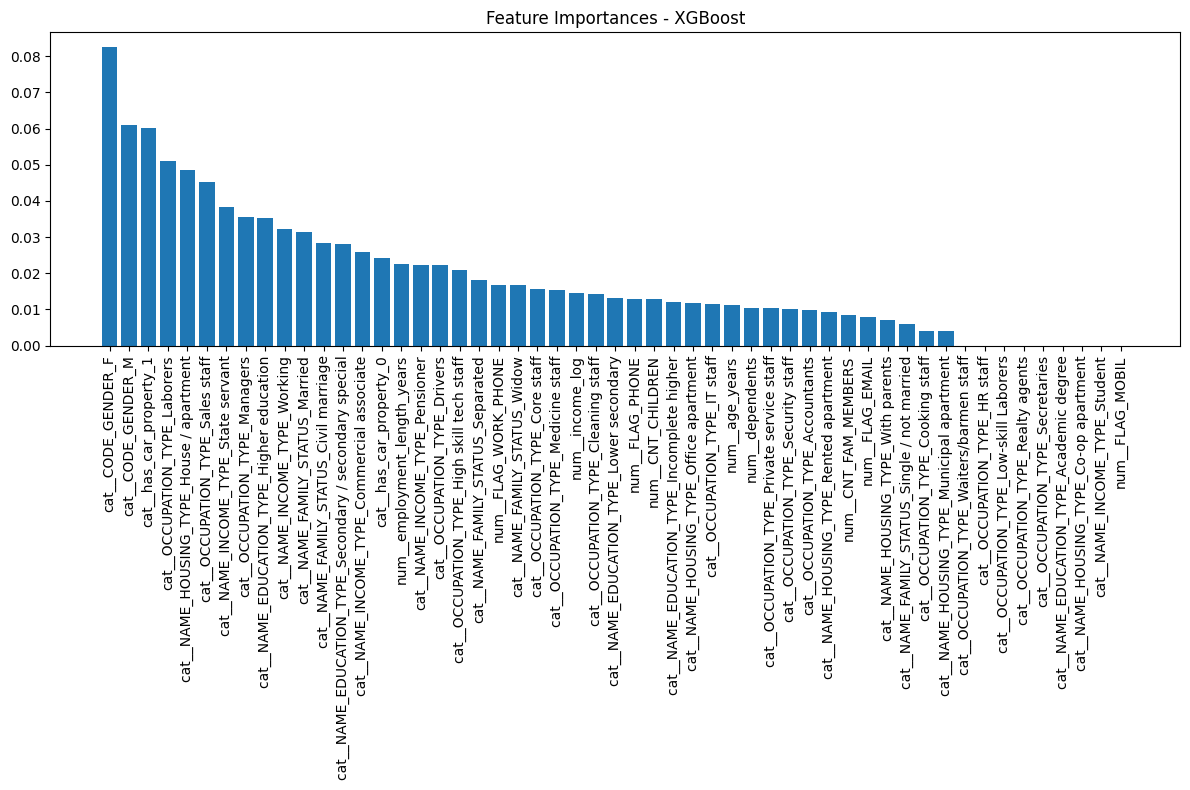


Top 10 most important features:
cat__CODE_GENDER_F: 0.0825
cat__CODE_GENDER_M: 0.0609
cat__has_car_property_1: 0.0601
cat__OCCUPATION_TYPE_Laborers: 0.0510
cat__NAME_HOUSING_TYPE_House / apartment: 0.0486
cat__OCCUPATION_TYPE_Sales staff: 0.0451
cat__NAME_INCOME_TYPE_State servant: 0.0383
cat__OCCUPATION_TYPE_Managers: 0.0357
cat__NAME_EDUCATION_TYPE_Higher education: 0.0354
cat__NAME_INCOME_TYPE_Working: 0.0322


In [28]:
# Feature importance for the best model
if best_idx == 0:
    best_model = lr_model
    # For logistic regression, get coefficients
    if hasattr(best_model, 'coef_'):
        feature_names = X.columns
        coefficients = best_model.coef_[0]
        indices = np.argsort(np.abs(coefficients))[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance - {best_model_name}')
        plt.bar(range(len(indices)), np.abs(coefficients[indices]), align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 most important features:")
        for i in range(min(10, len(feature_names))):
            print(f"{feature_names[indices[i]]}: {coefficients[indices[i]]:.4f}")
elif best_idx == 1:
    best_model = rf_model
    # For random forest, get feature importances
    if hasattr(best_model, 'feature_importances_'):
        feature_names = X.columns
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importances - {best_model_name}')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 most important features:")
        for i in range(min(10, len(feature_names))):
            print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
else:
    best_model = xgb_model
    # For XGBoost, get feature importances
    if hasattr(best_model, 'feature_importances_'):
        feature_names = X.columns
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importances - {best_model_name}')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 most important features:")
        for i in range(min(10, len(feature_names))):
            print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

- Gender (`CODE_GENDER_F` and `CODE_GENDER_M`): These are the most important features, with female (F) having a higher importance score than male (M).

- Car/Property Ownership (`has_car_property_1`): This feature is also highly important, suggesting that owning a car or property significantly impacts the model's predictions.

- Occupation Type:

  - Laborers and Sales staff are among the top features, indicating that occupation plays a key role in the model.

- Housing Type (House / apartment): This feature is important, suggesting that the type of housing affects the predictions.

- Income Type (State servant and Working): These features are moderately important, indicating that the source of income influences the model.

- Education Level (Higher education): This feature is also important, suggesting that higher education impacts the predictions.

In [29]:
# Save the best model
import joblib
joblib.dump(best_model, 'best_risk_model.pkl')
print(f"\nBest model saved as 'best_risk_model.pkl'")


Best model saved as 'best_risk_model.pkl'


### 4. Integration of Model Versioning & Experiment Tracking with MLflow

#### **Objective**
To track experiments, log model parameters and metrics, and support model versioning for future improvements, we integrate MLflow into our workflow.
   
1. **Set Up an Experiment**
 Initialize MLflow tracking 

In [34]:
import mlflow
import mlflow.sklearn

# Set MLflow tracking URI (default: local directory)
mlflow.set_tracking_uri("mlruns")  # Can be changed to a remote server

# Set the experiment name
mlflow.set_experiment("Risk_Scoring_Model_Experiments")

2025/03/09 17:39:50 INFO mlflow.tracking.fluent: Experiment with name 'Risk_Scoring_Model_Experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:C:/myProjects/Risk-Scoring-Underwriting/mlruns/676348012949655648', creation_time=1741538390238, experiment_id='676348012949655648', last_update_time=1741538390238, lifecycle_stage='active', name='Risk_Scoring_Model_Experiments', tags={}>

2. **Start a Run and Log Details**

In [42]:
def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test, params={}):
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_pred_proba)
        }

        # Log metrics
        mlflow.log_metrics(metrics)

        # Log model
        mlflow.sklearn.log_model(model, model_name)

        print(f"Logged {model_name} with metrics: {metrics}")

# Train and log models
train_and_log_model(lr_model, "Logistic Regression", X_train_bal, y_train_bal, X_test, y_test, {"C": 0.1, "class_weight": "balanced"})
train_and_log_model(rf_model, "Random Forest", X_train_bal, y_train_bal, X_test, y_test, {"n_estimators": 100, "max_depth": 8})
train_and_log_model(xgb_model, "XGBoost", X_train_bal, y_train_bal, X_test, y_test, {"n_estimators": 100, "max_depth": 4, "learning_rate": 0.05})

2025/03/09 18:02:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/09 18:02:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Logistic Regression with metrics: {'accuracy': 0.5416895227646736, 'precision': 0.018258006584854835, 'recall': 0.4959349593495935, 'f1_score': 0.03521939953810624, 'roc_auc': np.float64(0.524859745040469)}


2025/03/09 18:02:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/09 18:02:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Random Forest with metrics: {'accuracy': 0.9046900713110257, 'precision': 0.032679738562091505, 'recall': 0.16260162601626016, 'f1_score': 0.05442176870748299, 'roc_auc': np.float64(0.5778521343589778)}


2025/03/09 18:02:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/09 18:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged XGBoost with metrics: {'accuracy': 0.9380142622051564, 'precision': 0.04178272980501393, 'recall': 0.12195121951219512, 'f1_score': 0.06224066390041494, 'roc_auc': np.float64(0.5593272524997533)}


In [43]:
# Store models and their metrics
models = {
    "Logistic Regression": (lr_model, lr_metrics, "logistic_regression"),
    "Random Forest": (rf_model, rf_metrics, "random_forest"),
    "XGBoost": (xgb_model, xgb_metrics, "xgboost")
}

# Select the best model based on F1 Score
best_model_name, (best_model, best_metrics, best_mlflow_name) = max(models.items(), key=lambda x: x[1][1][3])  # F1 Score is at index 3

# Start a new MLflow run and log the best model
with mlflow.start_run(run_name=best_model_name) as run:
    run_id = run.info.run_id  # Capture run ID
    mlflow.sklearn.log_model(best_model, best_mlflow_name)  # Log the best model

# Register the best model
mlflow.register_model(
    model_uri=f"runs:/{run_id}/model",
    name=f"Risk_Scoring_{best_model_name.replace(' ', '_')}"
)

print(f"\n✅ Best Model Registered: {best_model_name}")


2025/03/09 18:03:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/09 18:03:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✅ Best Model Registered: XGBoost


Registered model 'Risk_Scoring_XGBoost' already exists. Creating a new version of this model...
Created version '3' of model 'Risk_Scoring_XGBoost'.
